In [10]:
import datasets
from datasets import load_dataset
from tqdm import tqdm
from knowledge_propagation.utils import vars, io, extractor
from scipy.stats import describe
from typing import List, Dict
import re
from copy import deepcopy
import pandas as pd

from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np

# Prepare sub_df whose answer is too long for shortening

In [462]:
long_answer_threshold = 30

entity_type_name_template_v1_answered_df_long = entity_type_name_template_v1_answered_df[entity_type_name_template_v1_answered_df.apply(lambda row: len(str(row["answer"]).strip()) > 30 , axis=1)]

In [463]:
entity_type_name_template_v1_answered_df_long

,entity_type,entity_type_tag,entity_name,template,question,answer
66,Person,person,Tudors,How many children did {person} have?,How many children did Tudors have?,"Henry VII had 7 children, and Henry VIII had 3..."
117,Person,person,Michael Jackson,What is the religion of {person}?,What is the religion of Michael Jackson?,"Jehovah's Witness (formerly), later associated..."
136,Person,person,Sitting Bull,What is the religion of {person}?,What is the religion of Sitting Bull?,Native American traditional spirituality
152,Person,person,Alexander Hamilton,What is the religion of {person}?,What is the religion of Alexander Hamilton?,Christian (Anglican/Episcopalian)
154,Person,person,Isaac Newton,What is the religion of {person}?,What is the religion of Isaac Newton?,"Christianity (specifically, he was an unorthod..."
...,...,...,...,...,...,...
4642,Country,country,Italy,Which religion has the most followers in {coun...,Which religion has the most followers in Italy?,Christianity (Roman Catholicism)
4650,Country,country,Philippines,Which religion has the most followers in {coun...,Which religion has the most followers in Phili...,Christianity (Roman Catholicism)
4686,Country,country,Armenia,Which religion has the most followers in {coun...,Which religion has the most followers in Armenia?,Christianity (Armenian Apostolic Church)
4698,Country,country,Mexico,Which religion has the most followers in {coun...,Which religion has the most followers in Mexico?,Christianity (Roman Catholicism)


In [464]:
entity_type_name_template_v1_answered_df_long.to_csv(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_curated_v1_answered_long.csv", index=False)

### (call llm to shorten)

In [465]:
entity_type_name_template_answered_ds_filtered_long_shortened = datasets.load_from_disk("/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_curated_v1_answered_long_shortened.hf")

In [466]:
entity_type_name_template_answered_df_filtered_long_shortened = entity_type_name_template_answered_ds_filtered_long_shortened.to_pandas()

In [467]:
# [a for a in entity_type_name_template_answered_df_filtered_long_shortened["shortened_answer"].to_list() if len(str(a)) > 30]

In [468]:
entity_type_name_template_answered_df_filtered_fixed_content = []


# for i, r in entity_type_name_template_answered_df_filtered_long_shortened.iterrows():
#     r_with_shortened_answer = entity_type_name_template_answered_df_filtered[entity_type_name_template_answered_df_filtered["question"] == r["question"]]
#     assert len(r_with_shortened_answer) == 1, r

for i, r in entity_type_name_template_v1_answered_df.iterrows():
    r_with_shortened_answer = entity_type_name_template_answered_df_filtered_long_shortened[entity_type_name_template_answered_df_filtered_long_shortened["question"] == r["question"]]
    
    if len(r_with_shortened_answer) == 0:
        if r["answer"].endswith("."):
            r["answer"] = r["answer"][:-1]
        entity_type_name_template_answered_df_filtered_fixed_content.append(r)
        continue
    assert len(r_with_shortened_answer) == 1, r
    new_r = deepcopy(r)
    new_r["answer"] = r_with_shortened_answer.iloc[0]["shortened_answer"]
    if new_r["answer"].endswith("."):
        new_r["answer"] = new_r["answer"][:-1]
    entity_type_name_template_answered_df_filtered_fixed_content.append(new_r)
entity_type_name_template_answered_df_filtered_shorten = pd.DataFrame(entity_type_name_template_answered_df_filtered_fixed_content)
len(entity_type_name_template_answered_df_filtered_shorten)

4941

In [469]:
# entity_type_name_template_answered_ds_filtered_long_shortened[entity_type_name_template_answered_df_filtered_long_shortened["question"] == r["question"]]

In [472]:
answered_df_prefilter = entity_type_name_template_answered_df_filtered_shorten[entity_type_name_template_answered_df_filtered_shorten.apply(lambda row: "I don't know" not in str(row["answer"]), axis=1)]

In [473]:
len(answered_df_prefilter)

4856

In [485]:
len(answered_df_prefilter["template"].unique())

52

In [ ]:
# io.dump_jsonlines(
#      answered_df_prefilter.to_dict("records"), 
#      f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_v1_curated_answered_prefiltered.jsonl"
# )

In [154]:
# len(answered_df_prefilter)

In [568]:
# # change answer in generation files from model and see if llm_acc change
# eos_sft_df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-v2-lr2e-6-sample-10/syn_data_neurips_prefilter_v2/base_n=19945_prompt=no_w-gen_wo-icl_ice=False.xlsx")


In [569]:
# assert all([q1==q2 for q1, q2 in zip(entity_type_name_template_answered_df_filtered_shorten["question"].to_list(), eos_sft_df["question"].to_list())])

In [570]:
# new_eos_sft_df = []
# for i in range(len(entity_type_name_template_answered_df_filtered_shorten)):
#     shortend_r = entity_type_name_template_answered_df_filtered_shorten.iloc[i]
#     eos_sft_r = eos_sft_df.iloc[i]
#     assert shortend_r["question"] == eos_sft_r["question"]
#     new_eos_sft_r = deepcopy(eos_sft_r)
#     new_eos_sft_r["answer"] = shortend_r["answer"]
#     new_eos_sft_df.append(new_eos_sft_r)
# new_eos_sft_df = pd.DataFrame(new_eos_sft_df)

In [572]:
# new_eos_sft_df.drop(columns=["llm_accuracy"], inplace=True)

# Prepare a light-weight data for format alignment

In [477]:
sample_size = 10
light_weight_sft_content = []
for template, template_df in answered_df_prefilter.groupby("template"):
    light_weight_sft_content.extend(template_df.sample(sample_size).to_dict(orient="records"))
len(light_weight_sft_content)

520

In [478]:
io.dump_jsonlines(light_weight_sft_content, f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/model_prep/light_weight_sft_content_curated_v1_sample={sample_size}.jsonl",)

In [580]:
# len(entity_type_name_template_answered_df_filtered_shorten.iloc[20145]["answer"])

# measure llama3.2-1B-base model performance

In [38]:
# eos_sft_df = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/llama3.2-1B-eos-sft/syn_data_neurips_prefilter/base_n=17461_prompt=no_w-gen_wo-icl_ice=False.xlsx")
# eos_sft_df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-lr2e-6-sample-5/syn_data_neurips_prefilter/base_n=17461_prompt=no_w-gen_wo-icl_ice=False.xlsx")
# eos_sft_df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-lr2e-6-sample-10/syn_data_neurips_prefilter/base_n=17461_prompt=no_w-gen_wo-icl_ice=False.xlsx")
eos_sft_df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-curated-v1-lr2e-6-sample-10/syn_data_neurips_curated_prefilter/base_n=4856_prompt=no_w-gen_wo-icl_ice=False.xlsx")

In [39]:
# pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-v2-lr2e-6-sample-10/syn_data_neurips_prefilter_v2/base_n=19945_prompt=no_w-gen_wo-icl_ice=False.xlsx.bak").describe()

In [40]:
llm_threshold = 0.4

In [41]:
eos_sft_df.describe()

,id,predicted_answer_idx,exact_match,llm_accuracy
count,4856.000000,4856.0,4856.000000,4856.000000
mean,2427.500000,0.0,0.467257,0.696829
std,1401.950784,0.0,0.498978,0.400008
min,0.000000,0.0,0.000000,0.000000
25%,1213.750000,0.0,0.000000,0.300000
50%,2427.500000,0.0,0.000000,1.000000
75%,3641.250000,0.0,1.000000,1.000000
max,4855.000000,0.0,1.000000,1.000000


In [42]:
len(eos_sft_df[eos_sft_df["llm_accuracy"] > llm_threshold])

3432

In [43]:
eos_sft_df_filtered = eos_sft_df[eos_sft_df["llm_accuracy"] > llm_threshold]

In [44]:
# Counter(eos_sft_df[eos_sft_df["template"] == "Where was {invention} created?"]["answer"])

In [45]:
eos_sft_df_filtered.describe()

,id,predicted_answer_idx,exact_match,llm_accuracy
count,3432.000000,3432.0,3432.000000,3432.000000
mean,2504.935606,0.0,0.661131,0.939103
std,1447.663180,0.0,0.473394,0.132056
min,13.000000,0.0,0.000000,0.500000
25%,1248.750000,0.0,0.000000,1.000000
50%,2534.500000,0.0,1.000000,1.000000
75%,3825.500000,0.0,1.000000,1.000000
max,4854.000000,0.0,1.000000,1.000000


Text(0.5, 1.0, 'LLM Accuracy Distribution (without filtering)')

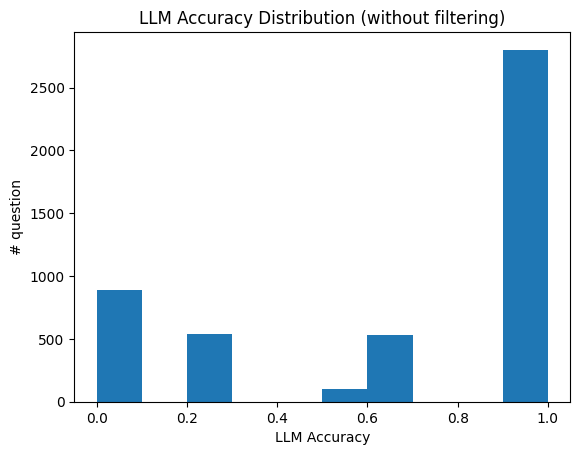

In [46]:
plt.hist(eos_sft_df["llm_accuracy"])
plt.xlabel("LLM Accuracy")
plt.ylabel("# question")
plt.title("LLM Accuracy Distribution (without filtering)")

In [47]:
len(eos_sft_df["answer"].to_list())

4856

In [48]:
vars.GPT_4_TOKENIZER("Writers, calligraphers, enthusiasts, professionals")

[54, 32929, 11, 1650, 54967, 388, 11, 43448, 11, 15749]

In [49]:
[a for a in eos_sft_df_filtered["answer"].to_list() if len(a) == 96]

['Destruction of the World Trade Center and Pentagon, mass casualties, and the War on Terror began']

In [50]:
[a for a in eos_sft_df_filtered["answer"].to_list() if len(vars.GPT_4_TOKENIZER(str(a))) >= 10]

['Christian (Anglican/Episcopalian)',
 'Christianity (Catholicism, then Protestantism)',
 'Colombey-les-Deux-Églises, France',
 'Woolsthorpe, Lincolnshire, England',
 'Gwanak-gu, Seoul, South Korea',
 'Ingrid Newkirk and Alex Pacheco',
 'Thomas Edison, Charles A. Coffin, Elihu Thomson, Edwin J. Houston',
 'Steve Jobs, Steve Wozniak, and Ronald Wayne',
 'Robert Wood Johnson, James Wood Johnson, and Edward Mead Johnson',
 'Pharmaceuticals, medical devices, consumer health products',
 'Navigators, hikers, sailors, surveyors',
 'Military, emergency services, law enforcement, executives, media',
 'Commuters, recreational riders, athletes, delivery workers',
 'Students, teachers, engineers, accountants, scientists',
 'Bell Labs (Daryl Chapin, Calvin Fuller, Gerald Pearson)',
 '1605 (Part I), 1615 (Part II)',
 'Carnivorous: fish, birds, mammals, reptiles, amphibians',
 'Omnivorous; eats plants, insects, and carrion',
 'Leaves, shoots, fruits, and flowers of trees',
 'Crustaceans, mollusks, al

In [51]:
Counter(eos_sft_df_filtered[eos_sft_df_filtered["answer"].apply(lambda x: len(str(x)) > 30)]["template"])

Counter({'Who are the primary users of {product}?': 53,
         'What is the diet of {species}?': 42,
         'What is the social structure of {species}?': 39,
         'What was the immediate outcome of {event}?': 39,
         'What is the primary function of {product}?': 29,
         'What triggered {event}?': 29,
         'What primary service or product does {organization} provide?': 20,
         'Where is {species} primarily native to?': 9,
         'Where did {event} happen?': 9,
         'What occupation is {person} most well-known for?': 6,
         'Who established {organization}?': 6,
         'What is the primary field or industry of {organization}?': 5,
         'What is the genre or of {creative_work}?': 5,
         'What is the primary threat to {species}?': 5,
         'Which religion has the most followers in {country}?': 5,
         'Where was {creative_work} produced or created?': 4,
         'When did {event} take place?': 3,
         'What is the religion of {pers

In [52]:
# [a for a in eos_sft_df["answer"].to_list() if len(str(a)) == 30]

Text(0.5, 1.0, 'Answer Length Distribution (without filtering)')

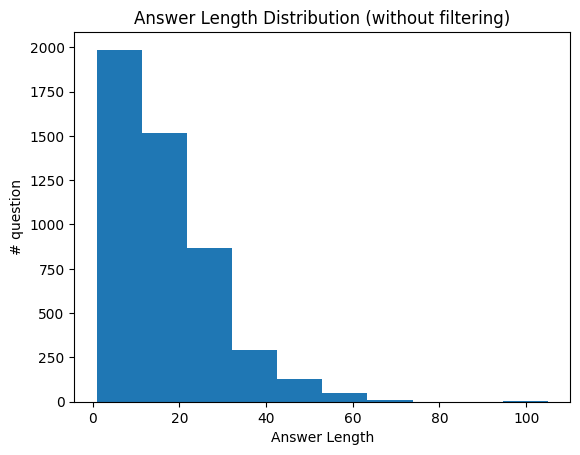

In [53]:
plt.hist([float(len(str(a))) for a in eos_sft_df["answer"].to_list()])
plt.xlabel("Answer Length")
plt.ylabel("# question")
plt.title("Answer Length Distribution (without filtering)")

In [122]:
eos_entity_type2count = {}
eos_entity_type2acc = {}
eos_entity_type2length = {}
eos_template2entity_names = defaultdict(list)

for i, d in eos_sft_df_filtered.iterrows():
    if d["entity_type"] not in eos_entity_type2count:
        eos_entity_type2count[d["entity_type"]] = defaultdict(int)
        eos_entity_type2acc[d["entity_type"]] = defaultdict(int)
        eos_entity_type2length[d["entity_type"]] = defaultdict(int)
        
    eos_entity_type2count[d["entity_type"]][d["template"]] += 1
    eos_template2entity_names[d["template"]].append(d["entity_name"])
    eos_entity_type2acc[d["entity_type"]][d["template"]] += d["llm_accuracy"]
    eos_entity_type2length[d["entity_type"]][d["template"]] += len(vars.GPT_4_TOKENIZER(str(d["answer"]).strip()))
        

In [178]:
# bad_question_templates = ["How many children did {person} have?", "What language family does {language} belong to?", "What is the national flower of {country}?", "When did {country} join the United Nations?", "What triggered {event}?", "What is the national anthem of {country} called?", "What is the date of {country}’s national day or independence day?", "What is the founding year of {country}?", "What legal system does {country} use?", "Which side is considered to have \"won\" {event}?", "What is the diet of {species}?"]
bad_question_templates = []
bad_entity_types = []

In [179]:
# eos_template2entity_names

In [180]:
counts = []
spotcheck_df_content = []
count_threshold = 0
entity_type2template_count = defaultdict(int)


for entity_type in eos_entity_type2count.keys():
    if entity_type in bad_entity_types:
        continue
    print(entity_type)
    for template in eos_entity_type2count[entity_type].keys():
        if template in bad_question_templates:
            continue
    
        acc_sum = eos_entity_type2acc[entity_type][template]
        count = eos_entity_type2count[entity_type][template]
        counts.append(count)
        
        acc = acc_sum / count
        spotcheck_df_content.append({
            "entity_type": entity_type,
            "template": template,
            "count": count,
            "accuracy": acc,
        })
        if count > count_threshold:
            entity_type2template_count[entity_type] += 1
            print(template, ":", acc, f"(count={count})")
    print("===" * 20)

Person
How many children did {person} have? : 0.9411764705882353 (count=17)
What is the religion of {person}? : 0.9262295081967216 (count=61)
What language was primarily spoken by {person}? : 0.9800000000000001 (count=80)
What occupation is {person} most well-known for? : 0.9102272727272728 (count=88)
What year did {person} pass away? : 1.0 (count=81)
What year was {person} born? : 1.0 (count=78)
Where did {person} die? : 0.9596153846153849 (count=52)
Where was the birthplace of {person}? : 0.9384615384615387 (count=65)
Organization
In what year was {organization} established? : 0.993421052631579 (count=76)
Where is the headquarters of {organization} located? : 0.9902173913043479 (count=92)
Where was {organization} established? : 0.9833333333333335 (count=90)
Who established {organization}? : 0.9054054054054054 (count=37)
What is the primary field or industry of {organization}? : 0.9009615384615388 (count=104)
What primary service or product does {organization} provide? : 0.88240740740

In [181]:
from itertools import combinations

def find_largest_intersection_at_least_m_sets(sets, m):
    """
    Find the largest intersection set using at least m sets from the given list of K sets.
    
    Args:
        sets: A list of sets, each containing elements
        m: Minimum number of sets to use for the intersection
    
    Returns:
        A tuple containing:
        - The largest intersection set
        - A list of indices of the sets that produce this largest intersection
    """
    if not sets or m <= 0 or m > len(sets):
        return set(), []  # Invalid input
    
    max_intersection_size = -1
    max_intersection_set = set()
    max_intersection_indices = []
    
    # Try finding the largest intersection with exactly j sets where j ranges from m to K
    for j in range(m, len(sets) + 1):
        # Try all combinations of j sets from the K sets
        for indices in combinations(range(len(sets)), j):
            # Calculate the intersection of the selected j sets
            selected_sets = [sets[i] for i in indices]
            intersection = set.intersection(*selected_sets)
            
            # Update maximum if this intersection is larger
            if len(intersection) > max_intersection_size:
                max_intersection_size = len(intersection)
                max_intersection_set = intersection
                max_intersection_indices = list(indices)
    
    return max_intersection_set, max_intersection_indices

In [182]:
set_list = [set(eos_template2entity_names[template]) for template in entity_type2templates["Person"]]

largest_overlap, set_ids = find_largest_intersection_at_least_m_sets(set_list, 5)
print(len(largest_overlap), len(set_ids), )

41 5


In [183]:
sanity_check_set = set_list[set_ids[0]]
for i in range(1, len(set_ids)):
    sanity_check_set = sanity_check_set.intersection(set_list[set_ids[i]])
len(sanity_check_set)

41

In [195]:
max_rel_config = dict([
    ("Person", 6),
    ("Event", 5),
    ("Species", 5),
    ("Language", 5),
    ("Organization", 5),
    ("Creative Work", 6),
    ("Country", 8),]
)

In [196]:
max_entity_config = [
    ("Person", 4),
    ("Event", 4),
    ("Species", 4),
    ("Language", 4),
    ("Organization", 4),
    ("Creative Work", 4),
    ("Country", 4),
]

In [197]:
eos_sft_df_filtered.columns

Index(['id', 'question_type', 'template', 'entity_name', 'entity_type',
       'input', 'stage', 'question', 'answer', 'predicted_answer_idx',
       'predicted_answer', 'exact_match', 'llm_accuracy'],
      dtype='object')

In [211]:
entity2nrel = max_rel_config
n_entity = 0
n_rel = 0
entity_type2filtered_entities = {}
entity_type2filtered_templates = {}
prefinalized_df_content = []

for entity_type, entity_templates in entity_type2templates.items():
    if entity_type not in entity2nrel:
        continue
    print(entity_type)
    entity_set_list = [set(eos_template2entity_names[template]) for template in entity_templates]
    largest_entity_overlap, largest_entity_set_ids = find_largest_intersection_at_least_m_sets(entity_set_list, entity2nrel[entity_type])
    entity_type2filtered_entities[entity_type] = largest_entity_overlap
    entity_type2filtered_templates[entity_type] = [entity_templates[i] for i in largest_entity_set_ids]
    prefinalized_df_content.append(
        eos_sft_df_filtered[(eos_sft_df_filtered["entity_type"] == entity_type) & (eos_sft_df_filtered["entity_name"].isin(largest_entity_overlap)) & (eos_sft_df_filtered["template"].isin(entity_type2filtered_templates[entity_type]))]
    )
    
    n_entity += len(largest_entity_overlap)
    n_rel += len(largest_entity_set_ids)
    print("# entity:", len(largest_entity_overlap))
    print("# templates:", len(largest_entity_set_ids))
print("===" * 20)

print("# total entity:", n_entity)
print("# total relation:", n_rel)

Person
# entity: 27
# templates: 6
Event
# entity: 25
# templates: 5
Species
# entity: 22
# templates: 5
Language
# entity: 22
# templates: 5
Organization
# entity: 46
# templates: 5
Creative Work
# entity: 21
# templates: 6
Country
# entity: 38
# templates: 8
# total entity: 201
# total relation: 40


In [199]:
prefinalized_df = pd.concat(prefinalized_df_content)

Text(0.5, 1.0, 'Answer Length Distribution (after filtering)')

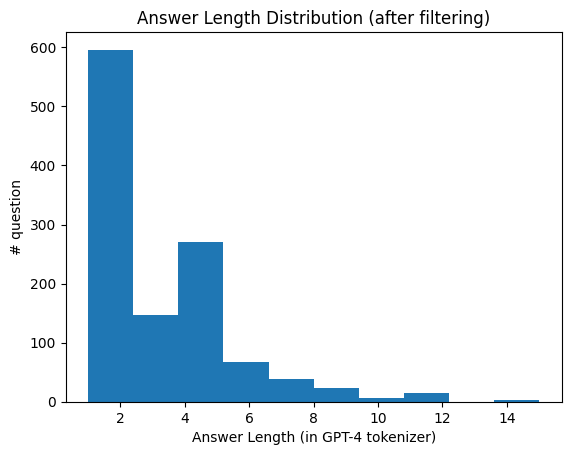

In [208]:
plt.hist([float(len(vars.GPT_4_TOKENIZER(str(a)))) for a in prefinalized_df["answer"].to_list()])
plt.xlabel("Answer Length (in GPT-4 tokenizer)")
plt.ylabel("# question")
plt.title("Answer Length Distribution (after filtering)")

In [201]:
float()

0.0

In [203]:
spotcheck_df_content = []
entity_spotcheck_df_content = []

for (entity_type, template), sub_df in prefinalized_df.groupby(["entity_type", "template"]):
    # pass
    acc = np.mean(sub_df["llm_accuracy"].to_list())
    length = float(np.mean([len(vars.GPT_4_TOKENIZER(a)) for a in sub_df["answer"].to_list()]))
    count = len(sub_df)
    # counts.append(count)
    rand_idx = np.random.randint(len(sub_df))
    for i, r in sub_df.iterrows():
        entity_spotcheck_df_content.append({
            "entity_type": entity_type,
            "entity_name": r["entity_name"],
        })
    
    spotcheck_df_content.append({
        "entity_type": entity_type,
        "template": template,
        "# entity": count,
        "avg_llm_accuracy": acc,
        "avg_answer_len (in GPT4 tokens)": length,
        "example_question": sub_df.iloc[rand_idx]["question"],
        "example_answer": sub_df.iloc[rand_idx]["answer"],
        "example_prediction": sub_df.iloc[rand_idx]["predicted_answer"],
    })

In [204]:
spotcheck_df = pd.DataFrame(spotcheck_df_content)
entity_spotcheck_df = pd.DataFrame(entity_spotcheck_df_content).drop_duplicates()
spotcheck_df = spotcheck_df.set_index(["entity_type", "template"], drop=True)
entity_spotcheck_df = entity_spotcheck_df.set_index(["entity_type",], drop=True)

In [205]:
spotcheck_df

# entity  \
entity_type   template                                                       
Country       What is the ISO alpha-2 code for {country}?               38   
              What is the calling code for {country}?                   38   
              What is the capital of {country}?                         38   
              What is the currency of {country}?                        38   
              What is the top-level internet domain for {coun...        38   
              What language in {country} has the most speakers?         38   
              Which ethnic group is the largest in {country}?           38   
              Which religion has the most followers in {count...        38   
Creative Work In which country was {creative_work} first rele...        21   
              What is the genre or of {creative_work}?                  21   
              What is the original language of {creative_work}?         21   
              When was {creative_work} released or published?           21   
              Where was {creative_work} produced or created?            21   
              Who is the creator of {creative_work}?                    21   
Event         What year did {event} end?                                25   
              When did {event} take place?                              25   
              Where did {event} happen?                                 25   
              Which side is considered to have "won" {event}?           25   
              Who was the most important leader or figure inv...        25   
Language      What is the ISO 639‑1 code for {language}?                22   
              What is the name of the alphabet or script of {...        22   
              What language family does {language} belong to?           22   
              What region is {language} native to?                      22   
              What writing system is used by {language}?                22   
Organization  In what year was {organization} established?              46   
              What is the primary field or industry of {organ...        46   
              What primary service or product does {organizat...        46   
              Where is the headquarters of {organization} loc...        46   
              Where was {organization} established?                     46   
Person        What language was primarily spoken by {person}?           27   
              What occupation is {person} most well-known for?          27   
              What year did {person} pass away?                         27   
              What year was {person} born?                              27   
              Where did {person} die?                                   27   
              Where was the birthplace of {person}?                     27   
Species       What is the diet of {species}?                            22   
              What is the primary threat to {species}?                  22   
              What is the social structure of {species}?                22   
              What type of organism is this {species}?                  22   
              Where is {species} primarily native to?                   22   

                                                                  avg_llm_accuracy  \
entity_type   template                                                               
Country       What is the ISO alpha-2 code for {country}?                 1.000000   
              What is the calling code for {country}?                     1.000000   
              What is the capital of {country}?                           1.000000   
              What is the currency of {country}?                          0.984211   
              What is the top-level internet domain for {coun...          1.000000   
              What language in {country} has the most speakers?           0.986842   
              Which ethnic group is the largest in {country}?             0.992105   
              W

In [206]:
spotcheck_df.to_excel(f"/u/zliu/datastor1/mend/spotcheck/spotcheck_df_curated_v1_rel.xlsx", index=True)

In [207]:
entity_spotcheck_df
entity_spotcheck_df.to_excel(f"/u/zliu/datastor1/mend/spotcheck/spotcheck_df_curated_v1_entity.xlsx", index=True)

In [610]:
# Counter(eos_sft_df_filtered[eos_sft_df_filtered.apply(lambda row: row["template"] == "Where is {species} primarily found?", axis=1)]["answer"])

In [ ]:
# spotcheck_df = pd.DataFrame(spotcheck_df_content)

In [611]:
# template_count_threshold = 1

In [ ]:
# print(f"# entity: {count_threshold}", f"# template: {template_count_threshold}", )
# len([k for k, v in entity_type2template_count.items() if v >= template_count_threshold])

# entity: 40 # template: 1


16

In [308]:
[k for k, v in entity_type2template_count.items() if v >= template_count_threshold]

['Historical Figure',
 'Business Figure',
 'Book',
 'Language',
 'Company',
 'Non-profit Organization',
 'University',
 'Invention',
 'Artwork',
 'Film',
 'Song',
 'Historical Event',
 'Software',
 'Species',
 'Author',
 'Country']